https://github.com/miladlink/TinyYoloV2

# Libraries

In [4]:
import os
import torch
from PIL import Image
from models.YOLOv2 import TinyYoloV2
from utils.YOLOv2 import *

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Model

In [6]:
def load_model(weights=None):
    """ loading pretrainde weights to built model"""
    model = TinyYoloV2()
    if weights:
       model.load_weights(weights)
       #model.load_state_dict (torch.load (weights))
    return model.to(device)

In [7]:
# downloading pretrained weights from source
# ! wget https://pjreddie.com/media/files/yolov2-tiny-voc.weights

In [8]:
model = load_model(weights = './models/yolov2-tiny-voc.weights')
# print(model)

# Prediction

In [9]:
class_names = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
               'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
               'dog', 'horse', 'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'TVmonitor']

In [10]:
def predict(model, img_path, save_to=None):
    assert os.path.exists(img_path), 'Error! Input image does not exists.'
    model.eval()
    img = Image.open(img_path).convert('RGB')
    print(ToTensor(img).shape)
 
    tic = time.time()
    # finding and filtering boxes
    boxes = filtered_boxes(model, img.resize((416, 416)), conf_thresh=0.66, nms_thresh=0.55, device=device)
    # print(boxes)
 
    toc = time.time()
    print('Prediction took {:.5f} ms.'.format((toc - tic) * 1000))
    # visualize image and bboxes
    pred_img = plot_boxes(img, boxes, save_to, class_names)
    
    return pred_img

torch.Size([1, 3, 333, 500])
Prediction took 241.35399 ms.


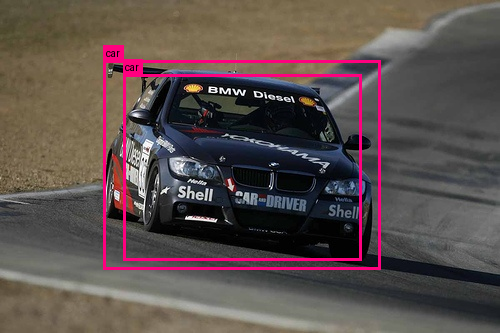

In [11]:
predict(model, './data/VOC2007/JPEGImages/009729.jpg')

# COCO loader

In [12]:
import torchvision.transforms as transforms
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt


create dataset

In [13]:
# root = "./data/COCO2017/val2017"
# annFile = "./data/COCO2017/annotations/instances_val2017.json"
root = "./data/VOC2007/JPEGImages"
annFile = "./data/VOC2007/annotations/val.json"
transform = transforms.Compose([
    transforms.ToTensor(),
])
coco_dataset = CocoDetection(root=root, annFile=annFile, transform=transform)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


create dataloader

In [14]:
import torch
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

def collate_fn(batch):
    return tuple(zip(*batch))

# Create a DataLoader for your COCO dataset
train_loader = DataLoader(coco_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(coco_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

inference and output json file containing prediction

In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from pycocotools.coco import COCO
import json
import cv2

predictions = []
for images, targets in val_loader: # * ASSUME ONE IMAGE PER BATCH
    with torch.no_grad():
        model.eval()
        # print(targets)
        image_id = targets[0][0]["image_id"]
        category_id = targets[0][0]["category_id"]
        img = images[0].unsqueeze(0).to(device)
        # print(img.shape)

        # imageN = img.cpu().squeeze().permute(1, 2, 0).numpy() # * just for sanity check, output image
        # imageN = cv2.cvtColor(imageN, cv2.COLOR_RGB2BGR)
        # plt.savefig("mygraph.png")

        resized_tensor_image = torch.nn.functional.interpolate(img, size=(416, 416), mode='bilinear', align_corners=False)
        # print(resized_tensor_image.shape)
        # * default 0.66, 0.55, higher conf -> more strict, higher nms -> more iou needed -> more strict
        boxes = filtered_boxes(model, resized_tensor_image, conf_thresh=0.6, nms_thresh=0.7, device=device) 
        
        # to_pil = transforms.ToPILImage() # * another sanity check
        # pil_image = to_pil(img.squeeze())
        # pred_img = plot_boxes(pil_image, boxes, None, class_names)
        # pil_image.save("./data/results/path_to_save_image.jpg")
        
        for box in boxes:    
            x_center, y_center, w, h, bbox_conf, cls_conf, cls = box
            x_min = int(max(0, (x_center - w / 2) * img.shape[3]))
            y_min = int(max(0, (y_center - h / 2) * img.shape[2]))
            width = int(min(img.shape[3], w * img.shape[3]))
            height = int(min(img.shape[2], h * img.shape[2]))
            predictions.append({
                'image_id': image_id,
                'category_id': int(cls),
                'bbox': [x_min, y_min, width, height],
                'score': round(float(cls_conf),2)
            })
    # break

# print(predictions)

with open('./data/results/predictions.json', 'w') as f:
    json.dump(predictions, f)

compare gt and prediction

install cocoapi: pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

C:\Users\anton\anaconda3\Lib\site-packages\pycocotools\cocoeval.py

issue #1: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.

fix: https://github.com/cocodataset/cocoapi/issues/356 at line 507,508, 518, 519

https://github.com/cocodataset/cocoapi/pull/354/commits/6c3b394c07aed33fd83784a8bf8798059a1e9ae4#diff-b13be02996507277fdef1503fc74ab7ac7679a15450b60982222f8ca051bc8ee

issue #2: module 'numpy' has no attribute 'float'

fix: changed x.astype(float) in line 379,380 of cocoeval.py to np.float64(x)

In [16]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gld = COCO('./data/VOC2007/annotations/val.json')
coco_rst = coco_gld.loadRes('./data/results/predictions.json')
cocoEval = COCOeval(coco_gld, coco_rst, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.236
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets